In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Fundamental Data Science for Data Scientist

# In Depth -  Support Vector Machines

SVM stands for "support vector machines". They are efficient and easy to use estimators.
They come in two kinds: SVCs, Support Vector Classifiers, for classification problems, and SVRs, Support Vector Regressors, for regression problems.

## Linear SVMs

The SVM module contains LinearSVC, which we already discussed briefly in the section on linear models.
Using ``SVC(kernel="linear")`` will also yield a linear predictor that is only different in minor technical aspects.

## Kernel SVMs
The real power of SVMs lies in using kernels, which allow for non-linear decision boundaries. A kernel defines a similarity measure between data points. The most common are:

- **linear** will give linear decision frontiers. It is the most computationally efficient approach and the one that requires the least amount of data.

- **poly** will give decision frontiers that are polynomial. The order of this polynomial is given by the 'order' argument.

- **rbf** uses 'radial basis functions' centered at each support vector to assemble a decision frontier. The size of the RBFs ultimately controls the smoothness of the decision frontier. RBFs are the most flexible approach, but also the one that will require the largest amount of data.

Predictions in a kernel-SVM are made using the formular

$$
\hat{y} = \text{sign}(\alpha_0 + \sum_{j}\alpha_j y_j k(\mathbf{x^{(j)}}, \mathbf{x}))
$$

where $\mathbf{x}^{(j)}$ are training samples, $\mathbf{y}^{(j)}$ the corresponding labels, $\mathbf{x}$ is a test-sample to predict on, $k$ is the kernel, and $\alpha$ are learned parameters.

What this says is "if $\mathbf{x}$ is similar to $\mathbf{x}^{(j)}$ then they probably have the same label", where the importance of each $\mathbf{x}^{(j)}$ for this decision is learned. [Or something much less intuitive about an infinite dimensional Hilbert-space]

Often only few samples have non-zero $\alpha$, these are called the "support vectors" from which SVMs get their name.
These are the most discriminant samples.

The most important parameter of the SVM is the regularization parameter $C$, which bounds the influence of each individual sample:

- Low C values: many support vectors... Decision frontier = mean(class A) - mean(class B)
- High C values: small number of support vectors: Decision frontier fully driven by most discriminant samples



The other important parameters are those of the kernel. Let's look at the RBF kernel in more detail:

$$k(\mathbf{x}, \mathbf{x'}) = \exp(-\gamma ||\mathbf{x} - \mathbf{x'}||^2)$$

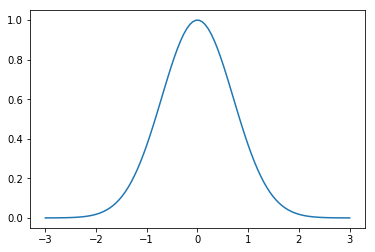

In [2]:
from sklearn.metrics.pairwise import rbf_kernel

line = np.linspace(-3, 3, 100)[:, np.newaxis]
kernel_value = rbf_kernel(line, [[0]], gamma=1)
plt.plot(line, kernel_value);

The rbf kernel has an inverse bandwidth-parameter gamma, where large gamma mean a very localized influence for each data point, and
small values mean a very global influence.
Let's see these two parameters in action:

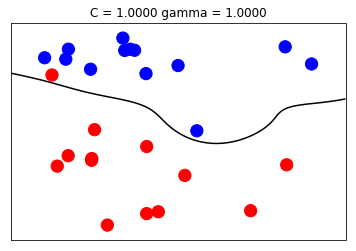

In [3]:
from figures import plot_svm_interactive
plot_svm_interactive()

## tune a SVM on the iris dataset

In [4]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree
from figures import plot_2d_separator

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import seaborn as sns

iris = pd.read_csv("iris.csv")

iris

,sepal_l,sepal_w,petal_l,petal_w,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.iloc[:, 0:4], 
                                                    iris['species'], 
                                                    train_size=0.7, 
                                                    random_state=123)
print("Labels for training and testing data")
print(y_train)


Labels for training and testing data
114     Iris-virginica
136     Iris-virginica
53     Iris-versicolor
19         Iris-setosa
38         Iris-setosa
110     Iris-virginica
23         Iris-setosa
9          Iris-setosa
86     Iris-versicolor
91     Iris-versicolor
89     Iris-versicolor
79     Iris-versicolor
101     Iris-virginica
65     Iris-versicolor
115     Iris-virginica
41         Iris-setosa
124     Iris-virginica
95     Iris-versicolor
21         Iris-setosa
11         Iris-setosa
103     Iris-virginica
74     Iris-versicolor
122     Iris-virginica
118     Iris-virginica
44         Iris-setosa
51     Iris-versicolor
81     Iris-versicolor
149     Iris-virginica
12         Iris-setosa
129     Iris-virginica
            ...       
120     Iris-virginica
137     Iris-virginica
125     Iris-virginica
147     Iris-virginica
39         Iris-setosa
84     Iris-versicolor
2          Iris-setosa
67     Iris-versicolor
55     Iris-versicolor
49         Iris-setosa
68     Iris-versicol

/Users/kris/anaconda3/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
from sklearn.svm import SVC 

C = 1.0
svclassifier = SVC(kernel='linear', C=C)  
svclassifier.fit(X_train, y_train) 


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 250000, 10), np.arange(10,70, 0.5))
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    plt.figure(figsize=(8,6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx,yy, X, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], x[:,1], c=y.astype(np.float))
    plt.show()
    
plotPredictions(svclassifier)

ValueError: X.shape[1] = 2 should be equal to 4, the number of features at training time

In [14]:
print("Predicting iris on the test set using K-NN")
t0 = time()
y_pred = svclassifier.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=iris['species'].unique()))
print(confusion_matrix(y_test, y_pred))


Predicting iris on the test set using K-NN
done in 0.001s
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        18
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.88      0.94        17

    avg / total       0.96      0.96      0.96        45

[[18  0  0]
 [ 0 10  0]
 [ 0  2 15]]


In [15]:
# get the separating hyperplane
w = svclassifier.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (svclassifier.intercept_[0]) / w[1]

# create a mesh to plot in
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx2, yy2 = np.meshgrid(np.arange(x_min, x_max, .2),
                     np.arange(y_min, y_max, .2))
Z = svclassifier.predict(np.c_[xx2.ravel(), yy2.ravel()])

Z = Z.reshape(xx2.shape)
ax.contourf(xx2, yy2, Z, cmap=plt.cm.coolwarm, alpha=0.3)
ax.scatter(X[:, 0], X[:, 1], c=y_test, cmap=plt.cm.coolwarm, s=25)
ax.plot(xx,yy)

ax.axis([x_min, x_max,y_min, y_max])
plt.show()

TypeError: unhashable type: 'slice'